# Importing Relevent Libraries

In [23]:
# for data visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for preprocessing
import pyspark.sql.functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.types import *
from pyspark.sql.functions import udf

from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler, PCA

# for model building and evaluation
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

SEED = 0

StatementMeta(idssmall, 2, 23, Finished, Available)

# Load the dataset

In [3]:
df = spark.read.options(header='True', inferSchema='True').csv("abfss://idspyspark@idspyspark.dfs.core.windows.net/NF_UNSW_NB15v2.csv").drop("Attack")
print("Dataset has {} rows & {} columns".format(df.count(), len(df.columns)))

StatementMeta(idssmall, 2, 3, Finished, Available)

Dataset has 2390275 rows & 44 columns

In [4]:
df.printSchema()

StatementMeta(idssmall, 2, 4, Finished, Available)

root
 |-- IPV4_SRC_ADDR: string (nullable = true)
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- IPV4_DST_ADDR: string (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- L7_PROTO: double (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- OUT_BYTES: integer (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- CLIENT_TCP_FLAGS: integer (nullable = true)
 |-- SERVER_TCP_FLAGS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- DURATION_IN: integer (nullable = true)
 |-- DURATION_OUT: integer (nullable = true)
 |-- MIN_TTL: integer (nullable = true)
 |-- MAX_TTL: integer (nullable = true)
 |-- LONGEST_FLOW_PKT: integer (nullable = true)
 |-- SHORTEST_FLOW_PKT: integer (nullable = true)
 |-- MIN_IP_PKT_LEN: integer (nullable = true)
 |-- MAX_IP_PKT_LEN: integer (nullable = true)
 |-- SRC_TO

In [5]:
df.limit(5).toPandas()

StatementMeta(idssmall, 2, 5, Finished, Available)

  IPV4_SRC_ADDR  L4_SRC_PORT  ... FTP_COMMAND_RET_CODE  Label
0    59.166.0.5         1305  ...                331.0      0
1    59.166.0.5         1305  ...                230.0      0
2    59.166.0.5         1305  ...                229.0      0
3    59.166.0.5         1305  ...                125.0      0
4    59.166.0.5         1305  ...                230.0      0

[5 rows x 44 columns]

In [6]:
df.select("Label").distinct().show()

StatementMeta(idssmall, 2, 6, Finished, Available)

+-----+
|Label|
+-----+
|    1|
|    0|
+-----+

In [7]:
target_col = "Label"
cate_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = list(set(df.columns) - set(cate_cols) - set([target_col]))

StatementMeta(idssmall, 2, 7, Finished, Available)

In [8]:
print("categorical columns:", cate_cols)
print("numerical columns:", num_cols)

StatementMeta(idssmall, 2, 8, Finished, Available)

categorical columns: ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR']
numerical columns: ['NUM_PKTS_512_TO_1024_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_PKTS', 'L4_DST_PORT', 'MIN_IP_PKT_LEN', 'NUM_PKTS_128_TO_256_BYTES', 'RETRANSMITTED_OUT_PKTS', 'MAX_IP_PKT_LEN', 'L4_SRC_PORT', 'OUT_BYTES', 'TCP_WIN_MAX_IN', 'SRC_TO_DST_SECOND_BYTES', 'ICMP_TYPE', 'TCP_WIN_MAX_OUT', 'NUM_PKTS_256_TO_512_BYTES', 'TCP_FLAGS', 'DNS_QUERY_ID', 'SHORTEST_FLOW_PKT', 'ICMP_IPV4_TYPE', 'DURATION_IN', 'SERVER_TCP_FLAGS', 'RETRANSMITTED_OUT_BYTES', 'OUT_PKTS', 'RETRANSMITTED_IN_BYTES', 'MIN_TTL', 'MAX_TTL', 'DNS_QUERY_TYPE', 'IN_BYTES', 'FTP_COMMAND_RET_CODE', 'NUM_PKTS_UP_TO_128_BYTES', 'DURATION_OUT', 'L7_PROTO', 'CLIENT_TCP_FLAGS', 'DNS_TTL_ANSWER', 'DST_TO_SRC_AVG_THROUGHPUT', 'PROTOCOL', 'IN_PKTS', 'NUM_PKTS_1024_TO_1514_BYTES', 'SRC_TO_DST_AVG_THROUGHPUT', 'FLOW_DURATION_MILLISECONDS', 'LONGEST_FLOW_PKT']

# Data Analysis and Preprocessing

## Impute missing values

In [9]:
# Impute numerical features
for col in num_cols:
    df = df.withColumn(col, df[col].cast('double'))
    mu = df.select(col).agg({col:'mean'}).collect()[0][0]
    df = df.withColumn(col, F.when(df[col].isNull(), mu)\
                       .otherwise(df[col]))

# Impute categorical features
for col in cate_cols:
    frq = df.select(col).groupby(col).count()\
                        .orderBy('count', ascending=False) \
                        .limit(1).collect()[0][0]
    df = df.withColumn(col, F.when((df[col].isNull() | 
                                    (df[col] == '')), frq) \
                            .otherwise(df[col]))

# Filter missing values
df = df.withColumn('label', df[target_col].cast('double'))
df = df.filter(df['label'].isNotNull())

StatementMeta(idssmall, 2, 9, Finished, Available)

In [10]:
# df.createOrReplaceTempView("network_traffic")
# spark.sql("SELECT duration from network_traffic").show()

StatementMeta(idssmall, 2, 10, Finished, Available)

## Exploratory Data Analysis
We plot various graphs to identify distributions, relationships or any pattern that is not visible by seeing raw data.

In [11]:
df_pandas = df[cate_cols+[target_col]].toPandas()

StatementMeta(idssmall, 2, 11, Finished, Available)

StatementMeta(idssmall, 2, 12, Finished, Available)

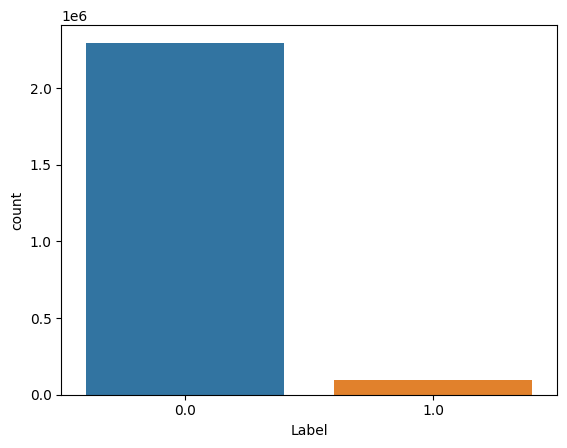

In [12]:
sns.countplot(x=df_pandas['Label'])
plt.show()

StatementMeta(idssmall, 2, 13, Finished, Available)

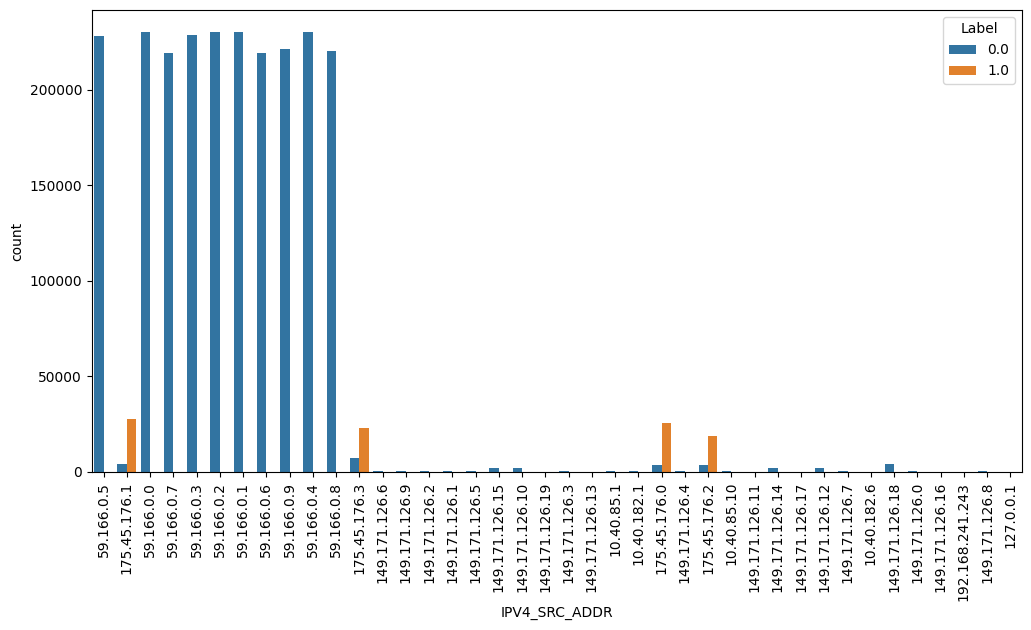

In [13]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
sns.countplot(x=cate_cols[0], data=df_pandas, hue="Label")
plt.show()

StatementMeta(idssmall, 2, 14, Finished, Available)

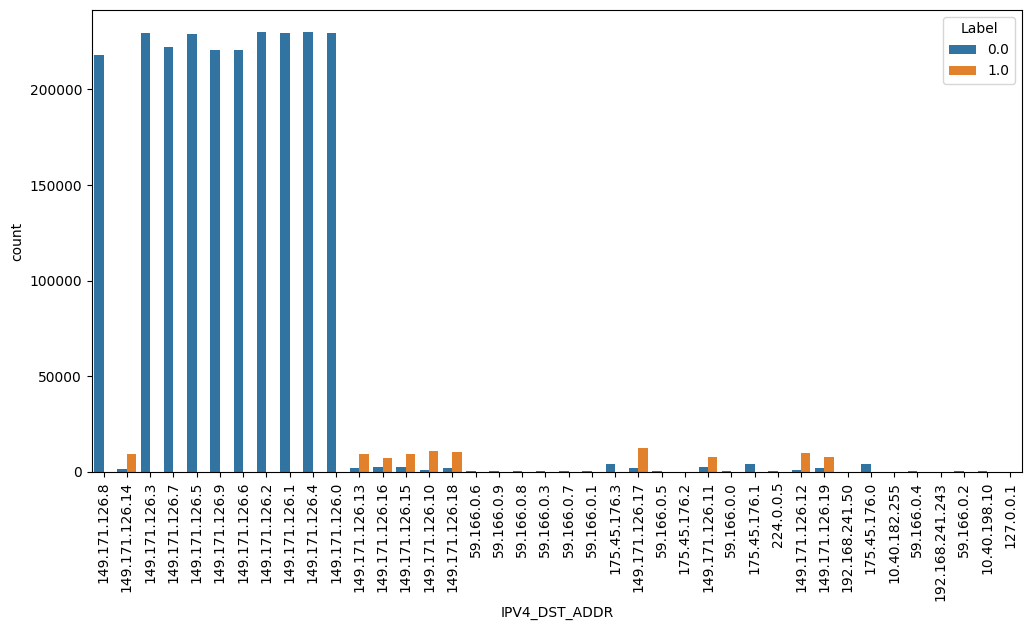

In [14]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
sns.countplot(x=cate_cols[1], data=df_pandas, hue="Label")
plt.show()

In [15]:
# n=len(num_cols)
# plt.figure(figsize=(16,n*5))
# for ax,cols in zip(axes,num_cols):
#     sns.histplot(df_pandas[col], ax=ax)
# plt.show()

StatementMeta(idssmall, 2, 15, Finished, Available)

## Data Encoding and Scaling

In [16]:
# helper function
def gen_preprocessor(df):
    # String Indexing for categorical features
    indexers = [StringIndexer(inputCol=col, 
                              outputCol="{}_idx".format(col),
                              handleInvalid="keep") \
                              for col in cate_cols]
    
    # One-hot encoding for categorical features
    encoders = [OneHotEncoder(inputCol="{}_idx".format(col), 
                              outputCol="{}_oh".format(col)) \
                              for col in cate_cols]

    # Concat Feature Columns
    assembler = VectorAssembler(inputCols = num_cols + \
                            ["{}_oh".format(col) for col in cate_cols], 
                            outputCol = "_features")
    
    # Standardize Features
    scaler = StandardScaler(inputCol='_features', 
                            outputCol='_feat')

    pca = PCA(k=5, inputCol="_feat", outputCol="features")

    preprocessor = Pipeline(stages = indexers + encoders + \
                                     [assembler, scaler, pca]).fit(df)

    return preprocessor

StatementMeta(idssmall, 2, 16, Finished, Available)

In [17]:
# Pre-Process
preprocessor = gen_preprocessor(df)   
df = preprocessor.transform(df)["features","label"]

StatementMeta(idssmall, 2, 17, Finished, Available)

In [24]:
df.printSchema()

StatementMeta(idssmall, 2, 24, Finished, Available)

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

In [25]:
r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

StatementMeta(idssmall, 2, 25, Finished, Available)

Pearson correlation matrix:
DenseMatrix([[ 1.00000000e+00,  4.55058591e-14,  8.82123551e-14,
               1.37289626e-14,  7.37550321e-15],
             [ 4.55058591e-14,  1.00000000e+00, -7.81027820e-14,
              -2.01236891e-14, -1.30120873e-14],
             [ 8.82123551e-14, -7.81027820e-14,  1.00000000e+00,
               1.18291972e-13,  1.11309506e-13],
             [ 1.37289626e-14, -2.01236891e-14,  1.18291972e-13,
               1.00000000e+00,  1.04607875e-15],
             [ 7.37550321e-15, -1.30120873e-14,  1.11309506e-13,
               1.04607875e-15,  1.00000000e+00]])

StatementMeta(idssmall, 2, 29, Finished, Available)

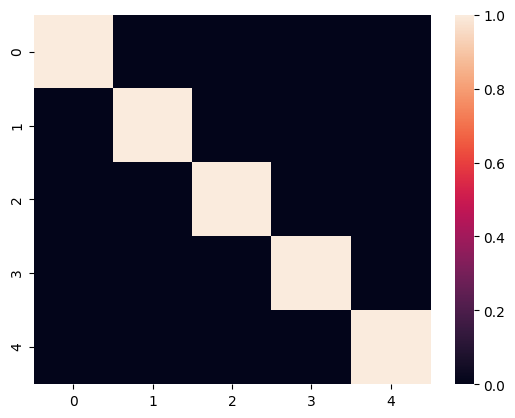

In [29]:
pcorr = np.array(list(map(abs,r1[0].toArray())))

sns.heatmap(pcorr)
plt.show()

## Train Test Split

In [18]:
train, test = df.randomSplit([0.7, 0.3], seed=SEED)
print("Training data has {} rows, while testing data has {} rows".format(train.count(), test.count()))

StatementMeta(idssmall, 2, 18, Finished, Available)

Training data has 1672977 rows, while testing data has 717298 rows

# Model Training

## Random Forest Classifier

In [19]:
rf = RandomForestClassifier()

StatementMeta(idssmall, 2, 19, Finished, Available)

In [30]:
paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees, [50]) \
            .addGrid(rf.maxDepth, [10]) \
            .addGrid(rf.maxBins, [32]) \
            .build()

StatementMeta(idssmall, 2, 30, Finished, Available)

In [31]:
# Train the 5-fold Cross Validator
cvModel = CrossValidator(estimator=Pipeline(stages = [rf]),
            estimatorParamMaps=paramGrid,
            evaluator=MulticlassClassificationEvaluator(),
            numFolds=5).fit(train)

StatementMeta(idssmall, 2, 31, Finished, Available)

In [32]:
# best params
bestParams=""
print("Best Params:")

hyperparams = cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]
for i in hyperparams:
    param_name = str(i).split("_")[-1]
    bestParams+="{} = {}\n".format(param_name, hyperparams[i])

print(bestParams)

StatementMeta(idssmall, 2, 32, Finished, Available)

Best Params:
numTrees = 50
maxDepth = 10
maxBins = 32

In [33]:
# helper function
def evaluate(predsAndLabels):
    log = {}

    evaluator = BinaryClassificationEvaluator()
    # Validation Score (AUROC)
    log['AUROC'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "areaUnderROC"})
    # Validation Score (AUPR)
    log['AUPR'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "areaUnderPR"})
    
    print("Area under ROC = {}".format(log['AUROC']))
    print("Area under PR = {}".format(log['AUPR']))

    # Overall statistics
    evaluator = MulticlassClassificationEvaluator()

    log['Accuracy'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "accuracy"})
    print("Accuracy = {}".format(log['Accuracy']))

    log['F1 Measure'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "f1"})
    log['precision'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "weightedPrecision"}) 
    log['recall'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "weightedRecall"})
    
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s" % \
            (log['precision'], log['recall'], log['F1 Measure']))

    return log

StatementMeta(idssmall, 2, 33, Finished, Available)

In [34]:
paramMap = cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]
tunedModel = rf.fit(train, paramMap)

StatementMeta(idssmall, 2, 34, Finished, Available)

In [35]:
predictionAndLabels = tunedModel.transform(train)
trainLog = evaluate(predictionAndLabels)

StatementMeta(idssmall, 2, 35, Finished, Available)

Area under ROC = 0.999105
Area under PR = 0.973070
Accuracy = 0.994866
[Overall]	precision = 0.995244 | recall = 0.994866 | F1 Measure = 0.994976

In [36]:
predictionAndLabels = tunedModel.transform(test)
testLog = evaluate(predictionAndLabels)

StatementMeta(idssmall, 2, 36, Finished, Available)

Area under ROC = 0.999137
Area under PR = 0.974201
Accuracy = 0.994849
[Overall]	precision = 0.995200 | recall = 0.994849 | F1 Measure = 0.994953